<a href="https://colab.research.google.com/github/ranton256/gbm_tutorial/blob/main/GBM_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#!pip install -q kaggle
!pip install -q kagglehub

In [4]:
# this assumes you have uploaded your kaggle.json file downloaded from Kaggle.com
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
# old way ! kaggle datasets download <name-of-dataset>
# new way
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("yeanzc/telco-customer-churn-ibm-dataset")

print("Path to dataset files:", dataset_path)


100%|██████████| 1.25M/1.25M [00:00<00:00, 57.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yeanzc/telco-customer-churn-ibm-dataset/versions/1


In [6]:
!ls {dataset_path}

Telco_customer_churn.xlsx


In [7]:
from pathlib import Path

# Find all .txt files in the current directory
files = Path(dataset_path).glob("*.xlsx")
files = list(files)
print("Files found:")
print('\n'.join([str(f) for f in files]))

datafile_path = files[0]
print(f"Using {datafile_path=}")

Files found:
/root/.cache/kagglehub/datasets/yeanzc/telco-customer-churn-ibm-dataset/versions/1/Telco_customer_churn.xlsx
Using datafile_path=PosixPath('/root/.cache/kagglehub/datasets/yeanzc/telco-customer-churn-ibm-dataset/versions/1/Telco_customer_churn.xlsx')


In [8]:
# Load the dataset
data = pd.read_excel(datafile_path)

# Preview the dataset
print(data.head())
print(data.info())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [9]:
data.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


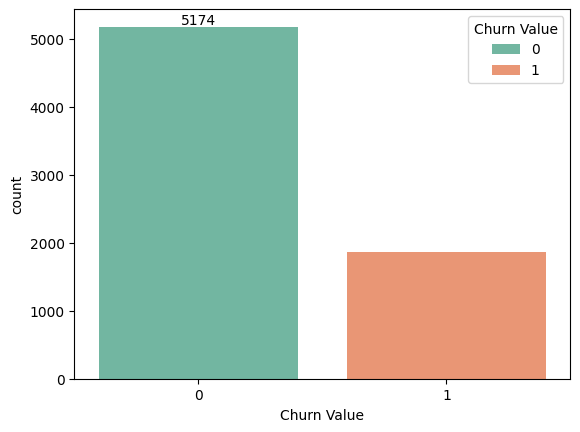

In [10]:
ax = sns.countplot(data=data, x='Churn Value', hue='Churn Value', palette='Set2')
ax.bar_label(ax.containers[0])
plt.show()

In [11]:
# inspect columns for missing data.
cols_na = [col for col in data.columns if data[col].isnull().sum() > 1]

for col in cols_na:
    print(f"{col}, {round(data[col].isnull().mean(), 4)} % Missing values")

Churn Reason, 0.7346 % Missing values


In [12]:
# Look at rows with missing values
data[data[cols_na[0]].isnull()]

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
1869,7590-VHVEG,1,United States,California,Los Angeles,90001,"33.973616, -118.24902",33.973616,-118.249020,Female,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,27,3964,NaN
1870,5575-GNVDE,1,United States,California,Los Angeles,90002,"33.949255, -118.246978",33.949255,-118.246978,Male,...,One year,No,Mailed check,56.95,1889.5,No,0,61,3441,NaN
1871,7795-CFOCW,1,United States,California,Los Angeles,90004,"34.076259, -118.310715",34.076259,-118.310715,Male,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,66,4307,NaN
1872,1452-KIOVK,1,United States,California,Los Angeles,90007,"34.027337, -118.28515",34.027337,-118.285150,Male,...,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No,0,43,4459,NaN
1873,6713-OKOMC,1,United States,California,Los Angeles,90008,"34.008293, -118.346766",34.008293,-118.346766,Female,...,Month-to-month,No,Mailed check,29.75,301.9,No,0,51,2013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


In [13]:
# Handling missing values
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')  # Convert TotalCharges to numeric

data.fillna({'Total Charges': data['Total Charges'].median()}, inplace=True)  # Fill missing values with median

# we are not actually going to use Churn Reason so don't worry about null values there.

# Drop rows without a value for target variable.
data.dropna(subset=['Churn Value'], inplace=True)



In [14]:
# Drop all the target or related variables from the dataset for training.
x_drop_cols = ['Churn Label', 'Churn Value', 'Churn Score', 'Churn Reason', 'CustomerID']
X = data.drop(x_drop_cols, axis=1)

# Split numerical and categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Categorical feature are: {categorical_features}")
print(f"Numerical feature are: {numerical_features}")

y = data['Churn Value']

X.info()

Categorical feature are: ['Country', 'State', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
Numerical feature are: ['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              7043 non-null   int64  
 1   Country            7043 non-null   object 
 2   State              7043 non-null   object 
 3   City               7043 non-null   object 
 4   Zip Code           7043 non-null   int64  
 5   Lat Long           7043 non-null   object 
 6   Latitude           7043 non-null   floa

In [15]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# Create CatBoost Pool for categorical features
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)


In [16]:
from google.colab import output
output.enable_custom_widget_manager()

In [17]:
# Create and train CatBoostClassifier
model = CatBoostClassifier(
    iterations=250,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=111,
    verbose=100,
    early_stopping_rounds=32
)

# You can also add plot=True, but this is not supported in Google Colab.
# however, you can save an HTML rendering of the plot using plot_file param.
model.fit(train_pool, eval_set=test_pool, verbose=True, plot_file="cb_training.html")

0:	test: 0.8021549	best: 0.8021549 (0)	total: 82.1ms	remaining: 20.4s
1:	test: 0.8205916	best: 0.8205916 (1)	total: 105ms	remaining: 13s
2:	test: 0.8206610	best: 0.8206610 (2)	total: 122ms	remaining: 10.1s
3:	test: 0.8294288	best: 0.8294288 (3)	total: 144ms	remaining: 8.88s
4:	test: 0.8311643	best: 0.8311643 (4)	total: 165ms	remaining: 8.09s
5:	test: 0.8328278	best: 0.8328278 (5)	total: 189ms	remaining: 7.7s
6:	test: 0.8336071	best: 0.8336071 (6)	total: 199ms	remaining: 6.92s
7:	test: 0.8357394	best: 0.8357394 (7)	total: 216ms	remaining: 6.54s
8:	test: 0.8394200	best: 0.8394200 (8)	total: 244ms	remaining: 6.52s
9:	test: 0.8411031	best: 0.8411031 (9)	total: 268ms	remaining: 6.42s
10:	test: 0.8430285	best: 0.8430285 (10)	total: 313ms	remaining: 6.8s
11:	test: 0.8460960	best: 0.8460960 (11)	total: 349ms	remaining: 6.92s
12:	test: 0.8459572	best: 0.8460960 (11)	total: 387ms	remaining: 7.06s
13:	test: 0.8476704	best: 0.8476704 (13)	total: 445ms	remaining: 7.49s
14:	test: 0.8479075	best: 0.8

In [18]:
from IPython.display import HTML

HTML(filename='cb_training.html')

Accuracy: 0.8119233498935415
ROC AUC Score: 0.8658255138340957

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1043
           1       0.67      0.54      0.60       366

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.81      1409



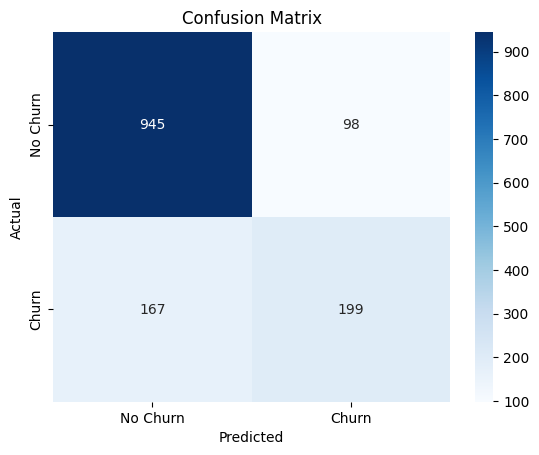

In [19]:
# Predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
# Feature importance
feature_importances = model.get_feature_importance(prettified=True)
print("\nFeature Importances:\n", feature_importances)


Feature Importances:
            Feature Id  Importances
0          Dependents    31.978720
1            Contract    19.947848
2       Tenure Months     6.986733
3    Internet Service     6.288389
4       Total Charges     5.015389
5     Online Security     4.067792
6      Payment Method     3.828826
7        Tech Support     3.348998
8     Monthly Charges     2.629763
9            Zip Code     2.390047
10     Multiple Lines     2.184379
11   Streaming Movies     2.181836
12      Online Backup     1.561416
13       Streaming TV     1.513628
14  Paperless Billing     1.455813
15  Device Protection     1.061439
16           Latitude     0.964482
17               CLTV     0.746934
18               City     0.616721
19           Lat Long     0.606978
20            Partner     0.213643
21             Gender     0.130090
22     Senior Citizen     0.110522
23      Phone Service     0.097466
24          Longitude     0.072149
25              Count     0.000000
26            Country     0.0000

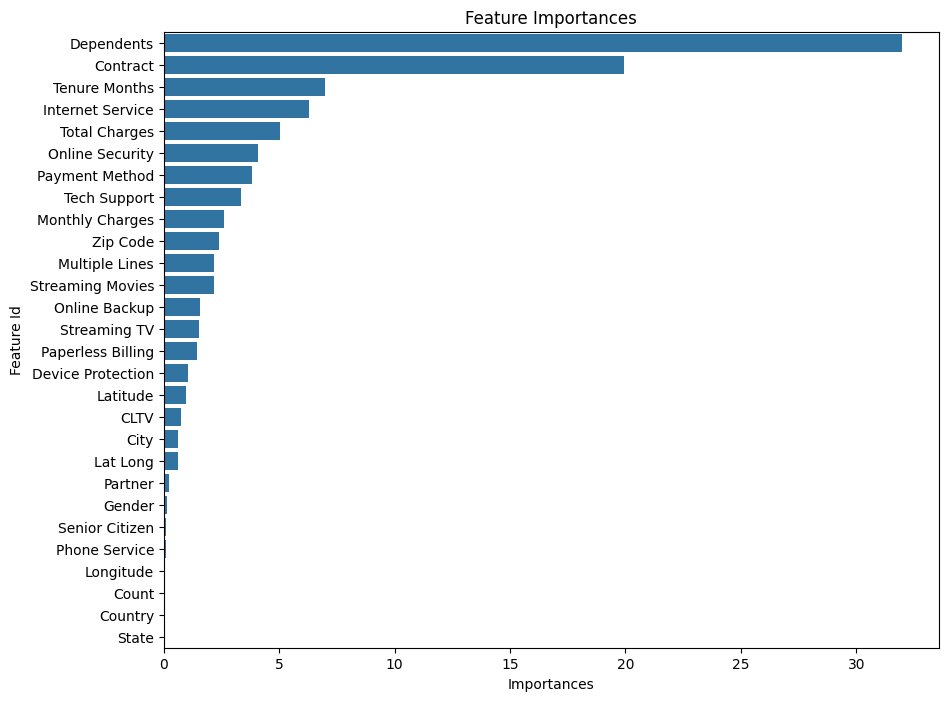

In [21]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importances', y='Feature Id', data=feature_importances.sort_values(by='Importances', ascending=False))
plt.title('Feature Importances')
plt.show()

In [22]:
# Save the model
model.save_model("catboost_customer_churn_model.cbm")

In [23]:
# Load and use the model (example)
loaded_model = CatBoostClassifier()
loaded_model.load_model("catboost_customer_churn_model.cbm")
new_predictions = loaded_model.predict(X_test)
print("New Predictions:", new_predictions[:50])

New Predictions: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 1]


## Hyperparameter Grid Search

In [24]:
# Create a new model that has not yet been fitted.
model = CatBoostClassifier(
    iterations=250,
    learning_rate=0.05,
    depth=6,
    # loss_function='Logloss', # TODO:
    eval_metric='AUC',
    random_seed=111,
    verbose=100,
    early_stopping_rounds=32
)

In [25]:
grid = {'learning_rate': [0.025, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
        }

grid_search_result = model.grid_search(grid,
                                       X=train_pool,
                                       verbose=100,
                                       cv=4, # 4 fold cross-validation
                                       plot_file='grid_search_output.html')
grid_search_result['params']

0:	test: 0.8240832	best: 0.8240832 (0)	total: 19.4ms	remaining: 4.84s
100:	test: 0.8711314	best: 0.8711314 (100)	total: 1.27s	remaining: 1.87s
200:	test: 0.8746951	best: 0.8747889 (186)	total: 2.49s	remaining: 607ms
249:	test: 0.8753597	best: 0.8753597 (249)	total: 3.06s	remaining: 0us

bestTest = 0.8753596841
bestIteration = 249

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8753597	best: 0.8753597 (0)	total: 3.09s	remaining: 2m
0:	test: 0.8240832	best: 0.8240832 (0)	total: 13.7ms	remaining: 3.42s
100:	test: 0.8763703	best: 0.8764446 (98)	total: 1.29s	remaining: 1.91s
Stopped by overfitting detector  (32 iterations wait)

bestTest = 0.880350301
bestIteration = 127

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.8240832	best: 0.8240832 (0)	total: 15.1ms	remaining: 3.77s
100:	test: 0.8699801	b

{'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 1}

In [26]:
print(list(grid_search_result.keys()))
display(grid_search_result['params'])
print(grid_search_result['cv_results'].keys())

['params', 'cv_results']


{'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 1}

dict_keys(['iterations', 'test-AUC-mean', 'test-AUC-std', 'test-Logloss-mean', 'test-Logloss-std', 'train-Logloss-mean', 'train-Logloss-std'])


In [27]:
max_examples = 10
for key in grid_search_result['cv_results'].keys():
  print(f"{key=}: {grid_search_result['cv_results'][key][:max_examples]}")


key='iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
key='test-AUC-mean': [0.8041216918560876, 0.8270666173538607, 0.8281617585775303, 0.8331489036382904, 0.8342344337279369, 0.8401399305024999, 0.8448529593032437, 0.8456095774937535, 0.8479473926615541, 0.8478506866324588]
key='test-AUC-std': [0.006098857353758765, 0.008176840403558929, 0.009808466378422736, 0.009465983329562258, 0.0077543041908030306, 0.008333388045672956, 0.008806688757910616, 0.009284744619831722, 0.010543364295901579, 0.010465351034374806]
key='test-Logloss-mean': [0.634580934535047, 0.5859370026659001, 0.55281481076691, 0.5280660644649011, 0.5082400544657804, 0.4909755078513265, 0.47321777632125556, 0.4646595102918321, 0.45270575953320513, 0.4468498753859177]
key='test-Logloss-std': [0.004183179938820113, 0.011811049149715104, 0.008422501396490593, 0.008109175137889581, 0.007099949578586821, 0.004880122618082968, 0.00643661540587337, 0.007098109783558012, 0.005721545322846332, 0.005428502323803017]
key='train-Logloss

In [28]:
HTML(filename='grid_search_output.html')

In [29]:
train_loss = grid_search_result['cv_results']['train-Logloss-mean']
test_loss = grid_search_result['cv_results']['test-Logloss-mean']

test_auc = grid_search_result['cv_results']['test-AUC-mean']


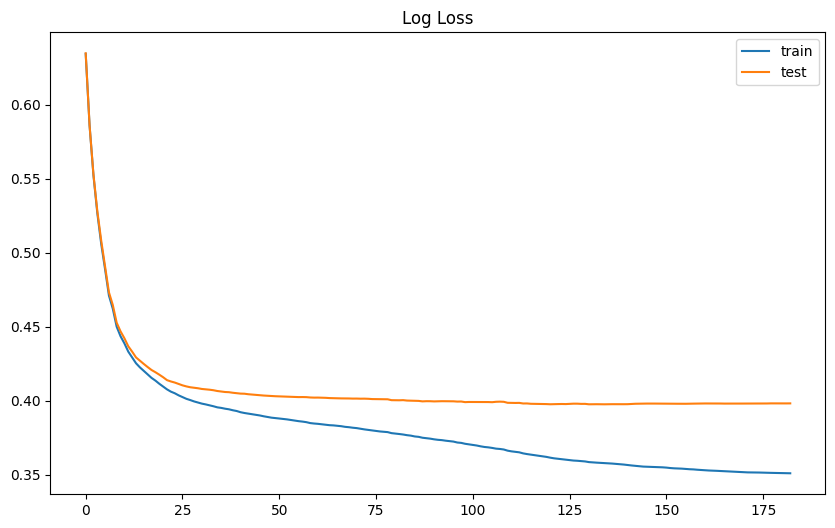

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()

plt.title('Log Loss')
plt.show()

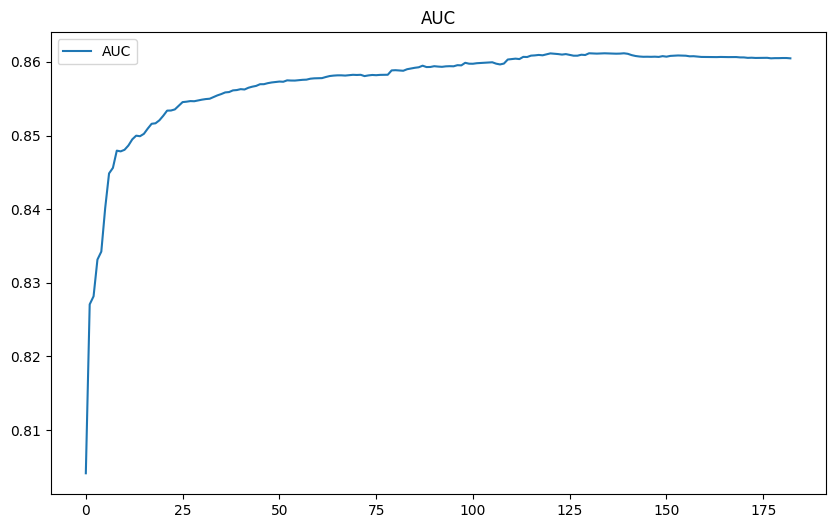

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(test_auc,label="AUC")
plt.legend()

plt.title('AUC')
plt.show()

Accuracy: 0.8197303051809794
ROC AUC Score: 0.8685616836678559

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1043
           1       0.69      0.55      0.61       366

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409



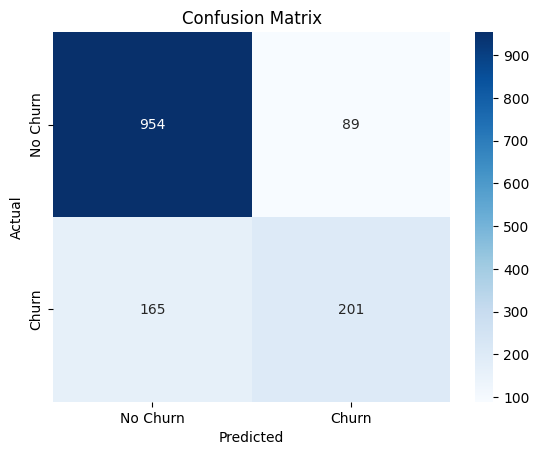

In [32]:
# eval the new version of our model
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()